# Import the YOLOv8 pretrained model

In [1]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image
PYTORCH_NO_CUDA_MEMORY_CACHING=1

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json

np.set_printoptions(precision=15)

from typing import Any, Dict, Generator, List
import matplotlib.pyplot as plt
import numpy as np

from dataset import dataset_utils, voc_annotate_and_Roboflow_export
from sam_predictor import predictor_utils, astro_sam
from losses import loss_utils, metrics_utils
from yolo_predictor import yolo_predictor_utils

In [2]:
kfold_iter = 1

device_id = 1
batch_size = 10
lr=6e-5
wd=0.0005
torch.cuda.set_device(device_id) # ❗️❗️❗️

In [3]:
wandb_track = False

if wandb_track:
    from datetime import datetime
    # !pip install wandb
    # !wandb login --relogin
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime.now()}")

## Dataset (YOLOv8 format)

**hyperparameters docs: https://docs.ultralytics.com/usage/cfg/#train**

The Yolov8 dataset for segmentation is structured as follows:
```
train/
  ├── images/
        ├── img_1.<extension>
        ├── img_2.<extension>
        │...
        └── img_n.<extension>
  ├── labels/
        ├── img_1_labels.txt
        ├── img_2_labels.txt
        │...
        └── img_n_labels.txt
```
each ```img_x_labels.txt``` contains multiple lines/annotations with corresponding class ID and segmentation coordinates:
```
<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>

In [4]:
yolo_dataset_path = f'./roboflow_datasets/xmm_om_artefacts-4-YOLO_no_augm/'

# yolo_dataset_path = f'../AstroArtefactToolkit_XMMoptical/mskf_YOLO_{kfold_iter-1}/'

# yolo_dataset_path = f'./roboflow_datasets/xmm_om_artefacts_512-20-YOLO-splits/iter_{kfold_iter}/'

In [5]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
# with open(yolo_dataset_path+f"_{kfold_iter-1}_data.yaml", 'r') as stream:
    
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'roboflow', 'test', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print(classes)

{0: 'central-ring', 1: 'other', 2: 'read-out-streak', 3: 'smoke-ring', 4: 'star-loop'}


# Couple YOLO bboxes with SAM

**load SAM model**

In [6]:
import sys
import PIL
from PIL import Image
sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')
import ft_mobile_sam
from ft_mobile_sam import sam_model_registry, SamPredictor #, build_efficientvit_l2_encoder

mobile_sam_checkpoint = './output_sam/ft_mobile_sam_final_2024-05-05 18:38:00.623724_last.pth'

yolov8_pretrained_model = YOLO('./yolov8-segm-ft_no_stars-n-iter1/yolov8n-seg/weights/best.pt');
yolov8_pretrained_model.to(f'cuda:{device_id}');

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

In [7]:
astrosam_model = astro_sam.AstroSAM(mobile_sam_model, device, predictor)

In [8]:
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'

train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

In [9]:
for name, param in mobile_sam_model.named_parameters():
    params_to_train = ['mask_tokens', 'output_upscaling', 'output_hypernetworks_mlps', 'iou_prediction_head']
    if 'mask_decoder' in name: # and any(s in name for s in params_to_train):
    # if False:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
print(f"🚀 The model has {sum(p.numel() for p in mobile_sam_model.parameters() if p.requires_grad)} trainable parameters.\n")
predictor_utils.check_requires_grad(mobile_sam_model)

🚀 The model has 4058340 trainable parameters.

❌ Param image_encoder.patch_embed.seq.0.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.bias  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv3.c.weigh

In [10]:
# check parameters sanity

for name, param in mobile_sam_model.named_parameters():
    if param is None:
        print(f"Parameter {name} is None")
    else:
        if torch.isnan(param.data).any():
            print(f"Parameter {name} contains NaN values")
        if torch.isinf(param.data).any():
            print(f"Parameter {name} contains infinity values")
        if torch.equal(param.data, torch.zeros_like(param.data)):
            print(f"Parameter {name} contains only zeros")

In [11]:
import time
import torch.nn.functional as F
import tqdm
from tqdm import tqdm

train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd) #betas=(0.9, 0.999))

In [12]:
batch_size

10

In [13]:
len(train_image_files), len(valid_image_files)

(659, 301)

## Define metrics

In [14]:
from torch import tensor
from torchmetrics.detection import MeanAveragePrecision
from pprint import pprint

metric_thresholds = [[0.5], [0.75], [0.5, 0.75, 0.9]]

# metric = MeanAveragePrecision(
#         iou_type = "segm", 
#         iou_thresholds = [0.5, 0.75, 0.90], 
#         max_detection_thresholds=[1, 10, 100],
#         class_metrics=True,
#         extended_summary=False)

# '''
# extended_summary:
# - ``ious``: a dictionary containing the IoU values for every image/class combination e.g.
#                   ``ious[(0,0)]`` would contain the IoU for image 0 and class 0. Each value is a tensor with shape
#                   ``(n,m)`` where ``n`` is the number of detections and ``m`` is the number of ground truth boxes for
#                   that image/class combination.
#                 - ``precision``: a tensor of shape ``(TxRxKxAxM)`` containing the precision values. Here ``T`` is the
#                   number of IoU thresholds, ``R`` is the number of recall thresholds, ``K`` is the number of classes,
#                   ``A`` is the number of areas and ``M`` is the number of max detections per image.
#                 - ``recall``: a tensor of shape ``(TxKxAxM)`` containing the recall values. Here ``T`` is the number of
#                   IoU thresholds, ``K`` is the number of classes, ``A`` is the number of areas and ``M`` is the number
#                   of max detections per image.
#                 - ``scores``: a tensor of shape ``(TxRxKxAxM)`` containing the confidence scores.  Here ``T`` is the
#                   number of IoU thresholds, ``R`` is the number of recall thresholds, ``K`` is the number of classes,
#                   ``A`` is the number of areas and ``M`` is the number of max detections per image.
# '''

## Run epochs

In [15]:
from collections import defaultdict

best_valid_loss = float('inf')
num_epochs = 1
n_epochs_stop = 5 + num_epochs//10
epoch_sam_loss_train_list, epoch_sam_loss_val_list, epoch_yolo_loss_train_list, epoch_yolo_loss_val_list = [], [], [], []
all_metrics = defaultdict(dict)

from collections import defaultdict
    
for epoch in range(num_epochs):

    # # train
    # astrosam_model.model.train()
    # epoch_sam_loss_train, epoch_yolo_loss_train, train_preds, train_gts, train_gt_classes, train_pred_classes, train_all_iou_scores, train_mask_areas, _ = astrosam_model.run_yolo_sam_epoch(
    #                                                                                                             yolov8_pretrained_model,
    #                                                                                                             phase='train',
    #                                                                                                             batch_size=batch_size, 
    #                                                                                                             image_files=train_image_files, 
    #                                                                                                             images_dir=train_dir, 
    #                                                                                                             num_batches=train_num_batches,
    #                                                                                                             optimizer=optimizer)

    # train (no gradients, only for mAP)
    astrosam_model.model.train()
    epoch_sam_loss_train, epoch_yolo_loss_train, train_preds, train_gts, train_gt_classes, train_pred_classes, train_all_iou_scores, train_mask_areas, _ = astrosam_model.run_yolo_sam_epoch(
                                                                                                                yolov8_pretrained_model,
                                                                                                                phase='val',
                                                                                                                batch_size=batch_size, 
                                                                                                                image_files=train_image_files, 
                                                                                                                images_dir=train_dir, 
                                                                                                                num_batches=train_num_batches,
                                                                                                                optimizer=None) 
    
    # validate
    astrosam_model.model.eval()
    with torch.no_grad():
        epoch_sam_loss_val, epoch_yolo_loss_val, valid_preds, valid_gts, valid_gt_classes, valid_pred_classes, valid_all_iou_scores, valid_mask_areas, pred_images = astrosam_model.run_yolo_sam_epoch(
                                                                                                                    yolov8_pretrained_model,
                                                                                                                    phase='val',
                                                                                                                    batch_size=batch_size, 
                                                                                                                    image_files=valid_image_files, 
                                                                                                                    images_dir=valid_dir, 
                                                                                                               num_batches=valid_num_batches)

    # Metrics
    for threshold in metric_thresholds:
        metric = MeanAveragePrecision(
        iou_type = "segm", 
        iou_thresholds = threshold, 
        max_detection_thresholds=[1, 10, 100],
        class_metrics=True,
        extended_summary=False)
        
        train_metrics = metrics_utils.mAP_metrics(metric,
        train_preds,
        train_gts, 
        train_gt_classes, 
        train_pred_classes, 
        train_all_iou_scores,
        train_mask_areas)  
            
        valid_metrics = metrics_utils.mAP_metrics(metric,
                valid_preds,
                valid_gts, 
                valid_gt_classes, 
                valid_pred_classes, 
                valid_all_iou_scores,
               valid_mask_areas) 
    
        all_metrics[tuple(threshold)] = {'train': train_metrics, 'valid': valid_metrics}
    
    epoch_sam_loss_train_list.append(epoch_sam_loss_train)
    epoch_sam_loss_val_list.append(epoch_sam_loss_val)
    epoch_yolo_loss_train_list.append(epoch_yolo_loss_train)
    epoch_yolo_loss_val_list.append(epoch_yolo_loss_val)

    print(f"epoch train SAM loss: {epoch_sam_loss_train}, epoch valid SAM loss: {epoch_sam_loss_val}")
    print(f"epoch train YOLO loss: {epoch_yolo_loss_train}, epoch valid YOLO loss: {epoch_yolo_loss_val}")
    print({'train/mAP50': all_metrics[tuple([0.5])]['train']['map'], 'train/mAP75': all_metrics[tuple([0.75])]['train']['map'], \
                   'train/mAP50-90': all_metrics[tuple([0.5, 0.75, 0.9])]['train']['map']})
    print({'valid/mAP50': all_metrics[tuple([0.5])]['valid']['map'], 'valid/mAP75': all_metrics[tuple([0.75])]['valid']['map'], \
                   'valid/mAP50-90': all_metrics[tuple([0.5, 0.75, 0.9])]['valid']['map']})
    
    if wandb_track:
        wandb.log({'train/mAP50': all_metrics[tuple([0.5])]['train']['map'], 'train/mAP75': all_metrics[tuple([0.75])]['train']['map'], \
                   'train/mAP50-90': all_metrics[tuple([0.5, 0.75, 0.9])]['train']['map']})
        wandb.log({'valid/mAP50': all_metrics[tuple([0.5])]['valid']['map'], 'valid/mAP75': all_metrics[tuple([0.75])]['valid']['map'], \
                   'valid/mAP50-90': all_metrics[tuple([0.5, 0.75, 0.9])]['valid']['map']})
        
        wandb.log({'train_SAM_loss': epoch_sam_loss_train, 'valid_SAM_loss': epoch_sam_loss_val})
     
    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = astrosam_model.model
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break

torch.save(best_model.state_dict(), f'yolo_sam_final.pth')

if wandb_track:
    run.finish()

Val Progress:   0%|          | 0/65 [00:00<?, ?it/s]                                                                                             /opt/conda/envs/env_py311/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
Val Progress: 100%|██████████| 30/30 [01:01<00:00,  2.06s/it]                                                                                    


574 574 574 574 574
torch.Size([8, 512, 512]) torch.Size([8]) torch.Size([8])
{'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32),
 'map': tensor(0.9041),
 'map_50': tensor(0.9041),
 'map_75': tensor(-1.),
 'map_large': tensor(1.),
 'map_medium': tensor(0.9310),
 'map_per_class': tensor([0.9897, 0.8244, 0.7965, 0.9483, 0.9618]),
 'map_small': tensor(0.8315),
 'mar_1': tensor(0.5017),
 'mar_10': tensor(0.9173),
 'mar_100': tensor(0.9289),
 'mar_100_per_class': tensor([0.9973, 0.8421, 0.8636, 0.9666, 0.9749]),
 'mar_large': tensor(1.),
 'mar_medium': tensor(0.9641),
 'mar_small': tensor(0.8555)}
298 298 298 298 298
torch.Size([2, 512, 512]) torch.Size([2]) torch.Size([2])
{'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32),
 'map': tensor(0.8179),
 'map_50': tensor(0.8179),
 'map_75': tensor(-1.),
 'map_large': tensor(0.7491),
 'map_medium': tensor(0.7714),
 'map_per_class': tensor([0.9642, 0.5816, 0.7556, 0.9160, 0.8723]),
 'map_small': tensor(0.7884),
 'mar_1': tensor(0.4646),
 '

In [ ]:
valid_metrics

In [ ]:
train_metrics

## Compute mean average precision

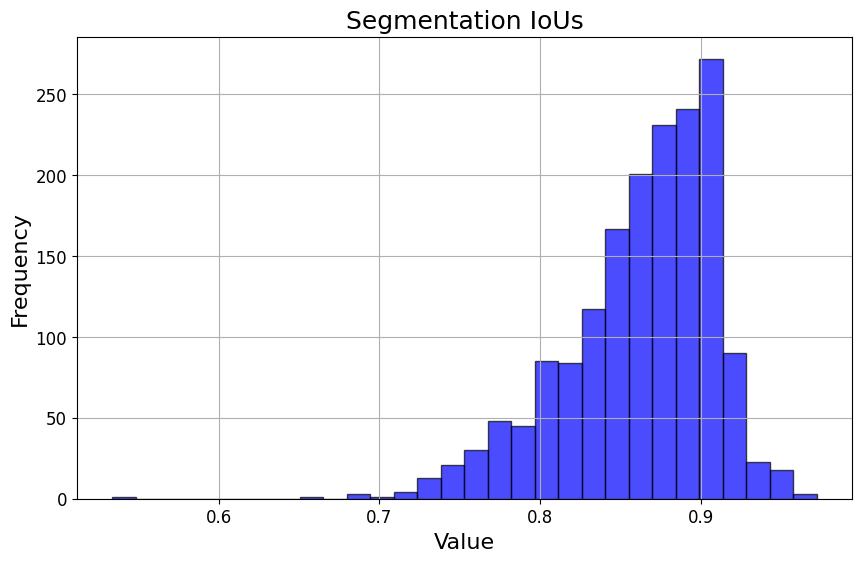

In [41]:
import numpy as np
import matplotlib.pyplot as plt

train_all_ious_flatten, train_mask_areas_flatten = metrics_utils.flatten_ious_areas(train_pred_classes, train_all_iou_scores, train_mask_areas)
valid_all_ious_flatten, valid_mask_areas_flatten = metrics_utils.flatten_ious_areas(valid_pred_classes, valid_all_iou_scores, valid_mask_areas)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_all_ious_flatten, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Segmentation IoUs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

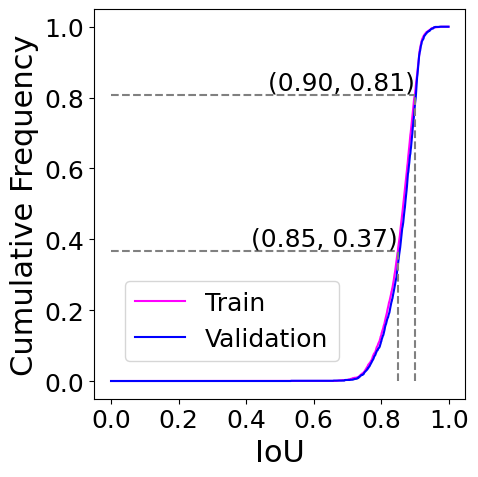

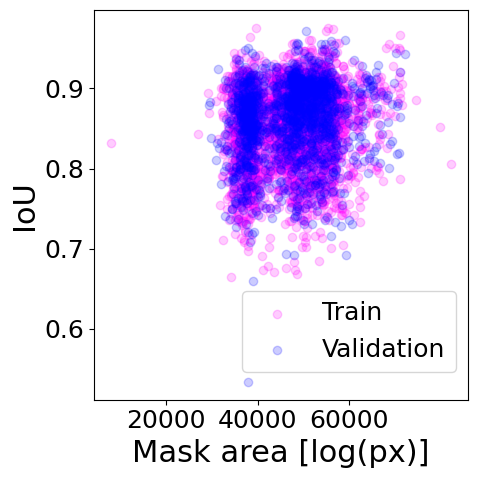

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14, 'font.family':'sans-serif'})

ious_train = train_all_ious_flatten
ious_valid = valid_all_ious_flatten
areas_train = train_mask_areas_flatten
areas_valid = valid_mask_areas_flatten

vals_train, base_train = np.histogram(ious_train, bins=1000, range=(0, 1), density=True)
cumulative_train = np.cumsum(vals_train * np.diff(base_train))
vals_valid, base_valid = np.histogram(ious_valid, bins=1000, range=(0, 1), density=True)
cumulative_valid = np.cumsum(vals_valid * np.diff(base_valid))

plt.figure(figsize=(5, 5))
plt.plot(base_train[:-1], cumulative_train, label='Train', color='magenta')
plt.plot(base_valid[:-1], cumulative_valid, label='Validation', color='blue')

quartiles_y = np.quantile(cumulative_train, [0.85, 0.9])
quartiles_x = np.interp(quartiles_y, cumulative_train, base_train[:-1])

for qx, qy in zip(quartiles_x, quartiles_y):
    plt.hlines(qy, xmin=0, xmax=qx, colors='grey', linestyles='dashed')
    plt.vlines(qx, ymin=0, ymax=qy, colors='grey', linestyles='dashed')
    plt.text(qx, qy, f'({qx:.2f}, {qy:.2f})', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('IoU', fontsize=22)
plt.ylabel('Cumulative Frequency', fontsize=22)
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(0.05, 0.2))
plt.tight_layout()
plt.savefig('./plots/cdf_ious.png', dpi=500)
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(np.log(areas_train), ious_train, alpha=0.2, label='Train', color='magenta')
plt.scatter(np.log(areas_valid), ious_valid, alpha=0.2, label='Validation', color='blue')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
x_ticks_positions = np.array([20000, 40000, 60000])*(np.max(np.log(areas_train))- np.min(np.log(areas_train)))/(np.max(areas_train)-np.min(areas_train))   # show orignal ticks but log plot
x_ticks_labels = ['20000', '40000', '60000']

plt.xticks(x_ticks_positions, x_ticks_labels, fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Mask area [log(px)]', fontsize=22)
plt.ylabel('IoU', fontsize=22)
plt.legend(fontsize=18, loc='lower right', bbox_to_anchor=(1, 0.04))
plt.tight_layout()
plt.savefig('./plots/ious_and_areas_log.png', dpi=500)
plt.show()

In [136]:
np.min(ious_train), np.min(ious_valid)

(0.6648576, 0.533699)

In [118]:
np.min(ious_train), np.max(ious_train), np.min(ious_valid), np.max(ious_valid)

(0.6648576, 0.9757648, 0.533699, 0.9721767)

In [92]:
areas_train = np.array(areas_train)
areas_train[areas_train<100]

array([84, 95, 97, 99, 96, 99, 95, 72, 96, 95, 82, 76, 99, 82, 80, 54, 78, 96, 94, 91, 97, 87, 84, 85, 83, 84, 95, 40,  3, 91, 87, 86, 56, 84, 93, 87, 86, 95, 97, 83, 68, 93], dtype=uint64)

In [209]:
len(valid_image_files), len(pred_images), len(valid_gts), len(valid_preds)

(301, 298, 298, 298)

# IoU FP FN TP TN plot

In [28]:
valid_coco_data = './roboflow_datasets/xmm_om_artefacts-3-COCO/valid/_annotations.coco.json'
with open(valid_coco_data, 'r') as file:
    valid_coco_data = json.load(file)

['S0505380801_L_png.rf.a10a81faad7f74f9841dfbbc1411c5de.jpg', 'S0653380401_M_png.rf.62e112848cb990ee64c13de705b3afae.jpg', 'S0721010601_V_png.rf.fa7f513f75a5f3b2e24f0ec6cb74a714.jpg', 'S0827210401_S_png.rf.1b9ae7243fd0e08a03934fafd549c8b5.jpg', 'S0883040201_L_png.rf.da52c974ef610c6ef8382c5bedfba9a5.jpg']
[109, 13, 253, 263, 238]
Mean IoU: 0.8340608 std: 0.045068193
Mean IoU: 0.9081238 std: 0.016572013
Mean IoU: 0.8793141 std: 0.046100236
Mean IoU: 0.8658059 std: 0.02405772
Mean IoU: 0.8759042 std: 0.025648117


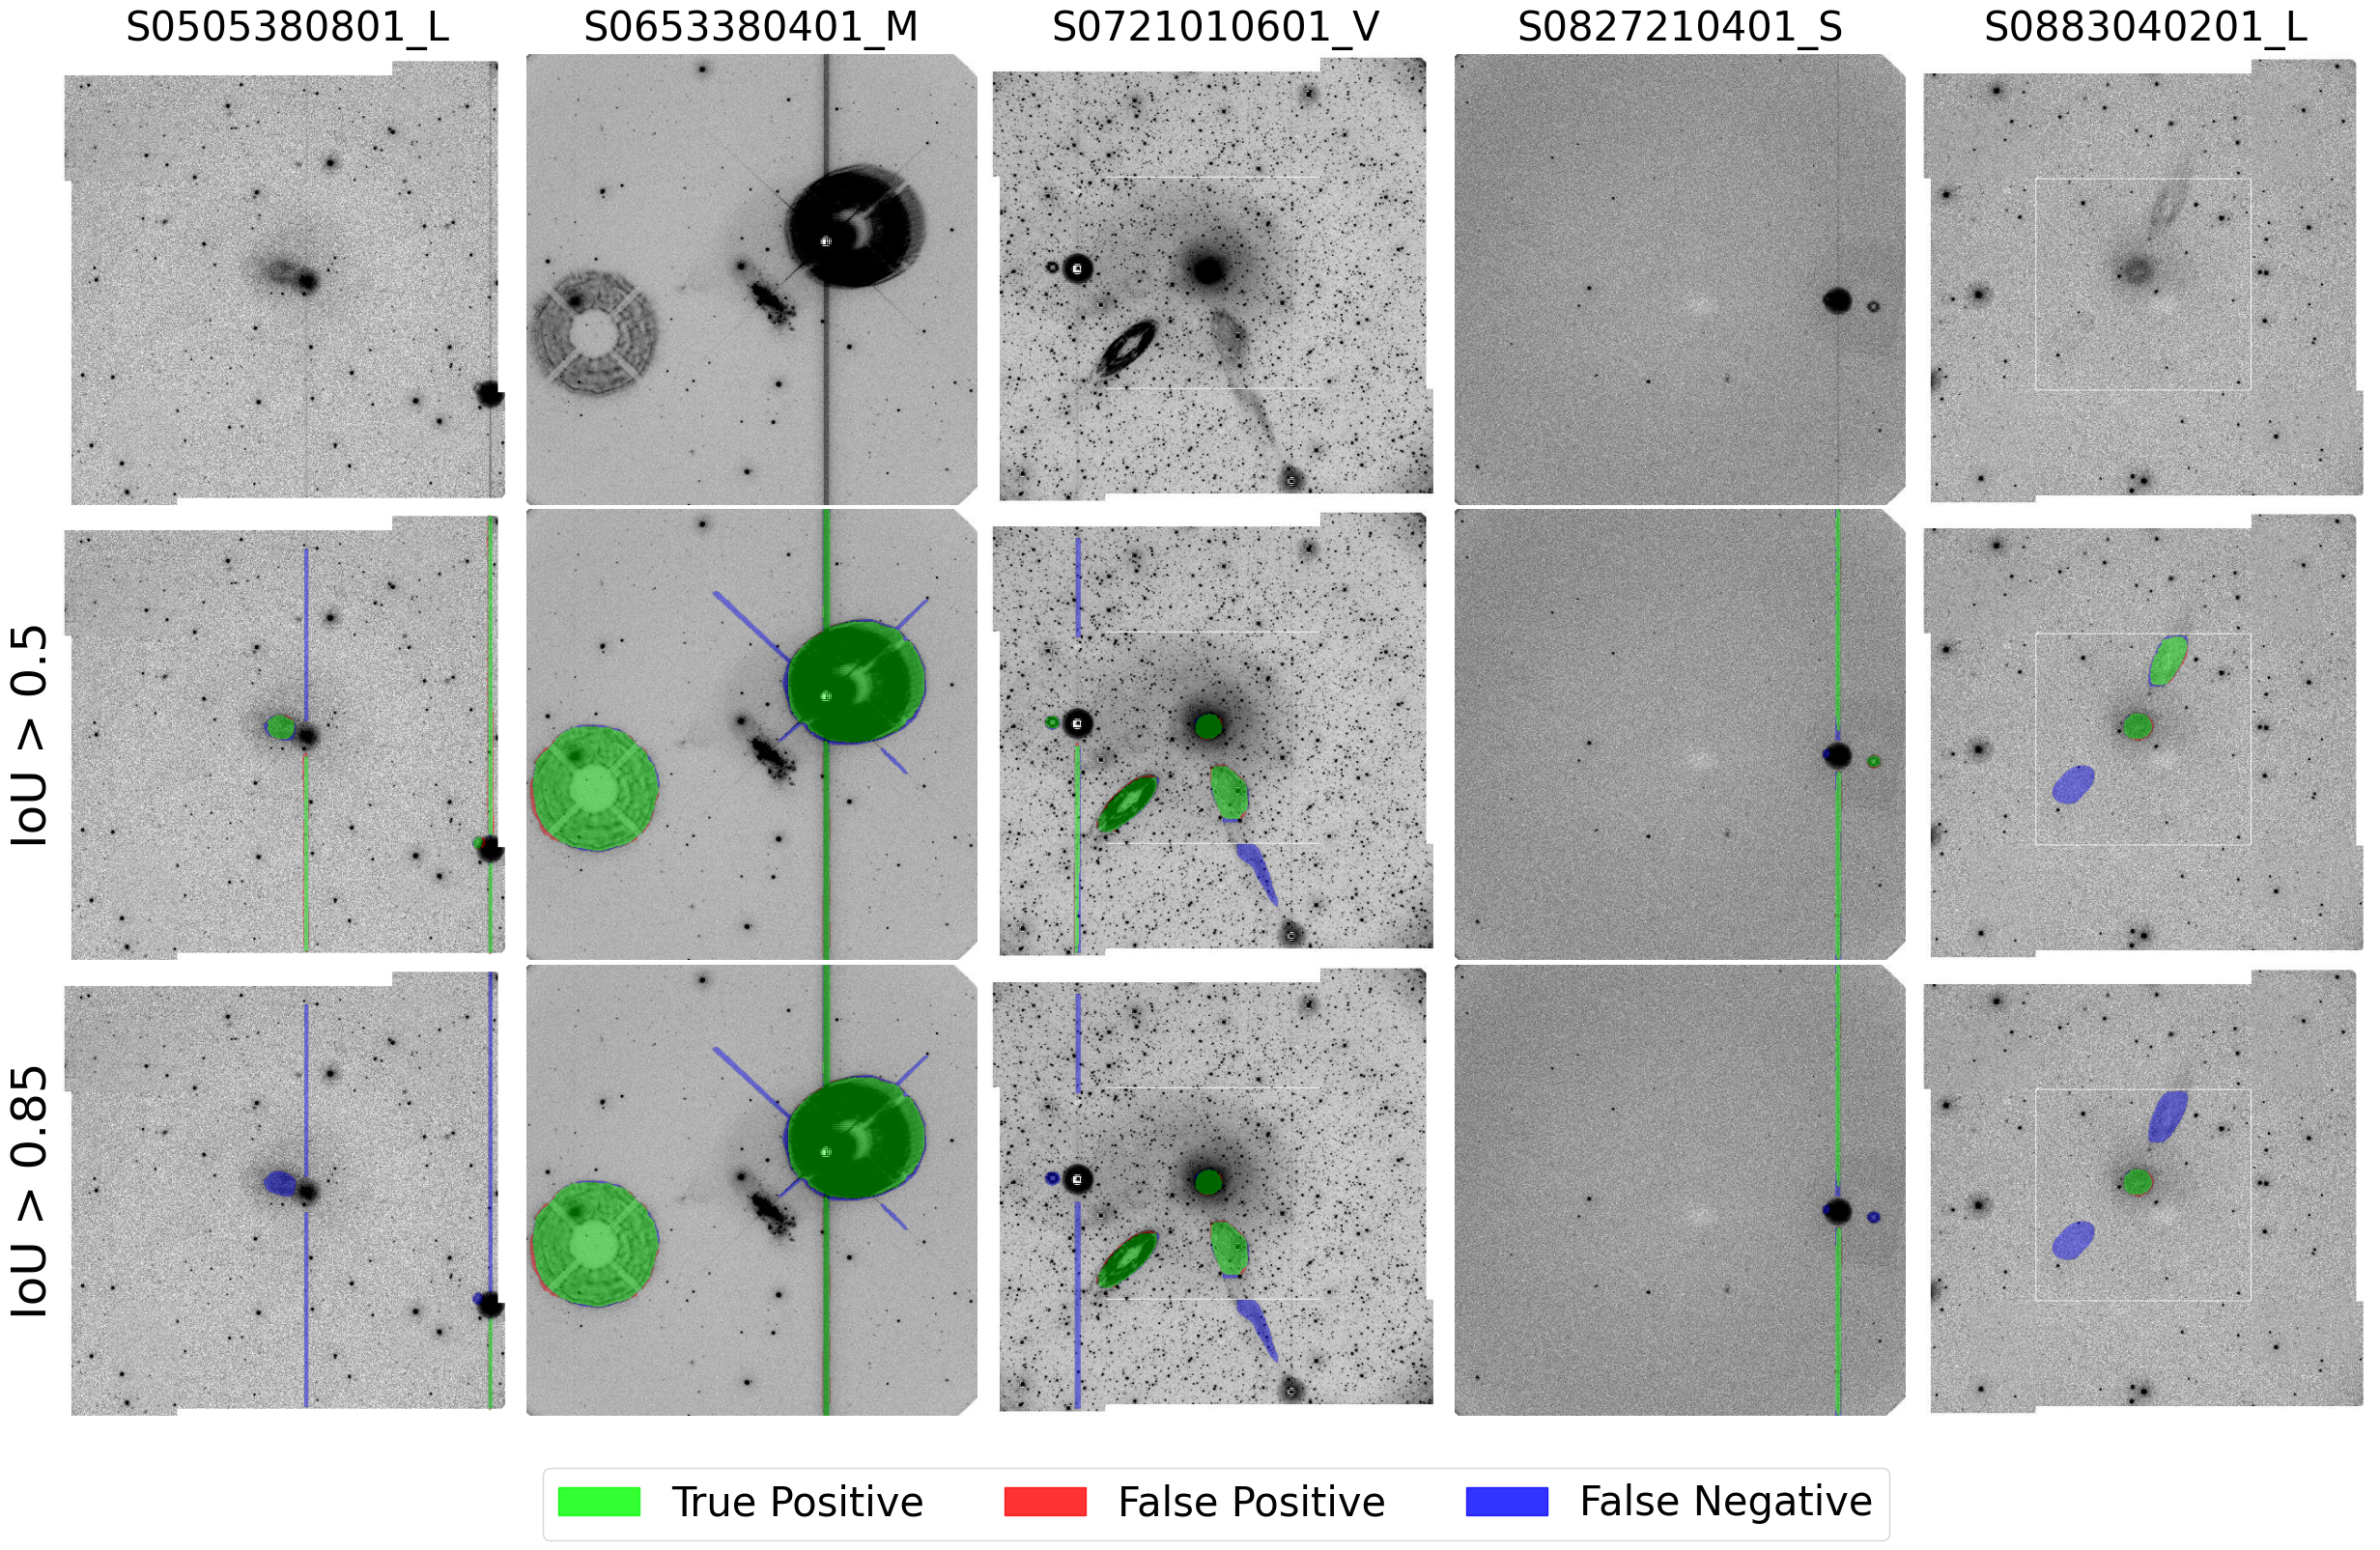

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import matplotlib.patches as mpatches
from matplotlib import style

random_indices = random.sample(range(len(pred_images)), 5)
random_indices = [109, 13, 253, 263, 238]
images = [pred_images[i] for i in random_indices]
selected_gts = [valid_gts[i] for i in random_indices]
selected_preds = [valid_preds[i] for i in random_indices]
selected_ious = [valid_all_iou_scores[i] for i in random_indices]

print(images)
print(random_indices)

def show_masks(masks, ax, random_color=False, colours=None):
    for i in range(len(masks)):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        elif colours is not None:
            color = np.array([c/255.0 for c in colours[i]]+[0.6])
            # color = np.array(list(colours[i])+[0.6])
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = masks[i].shape[-2:]
        mask_image = masks[i].reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)
        
def compute_iou(mask1, mask2):
    """Compute Intersection over Union of two binary masks."""
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def compute_metrics(gt_masks, pred_masks, iou_threshold, image=None):
    """Compute the True Positive, False Positive, and False Negative BINARY masks for multiple segmentations."""
    
    # if image is not None:
    #     plt.imshow(image)
    #     for mask in gt_masks:
    #         dataset_utils.show_mask(mask[0], plt.gca())
    #     plt.show()
    #     plt.close()
    
    #     plt.imshow(image)
    #     for mask in pred_masks:
    #         dataset_utils.show_mask(mask, plt.gca())
    #     plt.show()
    #     plt.close()
        
    combined_gt_mask = np.zeros_like(gt_masks[0][0], dtype=bool)
    combined_pred_mask = np.zeros_like(pred_masks[0], dtype=bool)
    filtered_pred_masks = np.zeros_like(pred_masks, dtype=bool)
    
    # print(gt_masks.shape, pred_masks.shape) # (N, 1, H, W), (N, H, W)
    for i, pred_mask in enumerate(pred_masks):
        max_iou = 0  # Max IoU for this pred_mask with any gt_mask
        for gt_mask in gt_masks:
            intersection = np.logical_and(gt_mask[0], pred_mask)
            union = np.logical_or(gt_mask[0], pred_mask)
            iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
            max_iou = max(max_iou, iou_score)  

        if max_iou > iou_threshold: # take IoUs above threshold
            filtered_pred_masks[i] = pred_mask

    for gt_mask in gt_masks:
        combined_gt_mask = np.logical_or(combined_gt_mask, gt_mask)

    for pred_mask in filtered_pred_masks:
        combined_pred_mask = np.logical_or(combined_pred_mask, pred_mask.astype(bool))

    true_positive_mask = np.logical_and(combined_gt_mask, combined_pred_mask)
    false_negative_mask = np.logical_and(combined_gt_mask, np.logical_not(combined_pred_mask))
    false_positive_mask = np.logical_and(combined_pred_mask, np.logical_not(combined_gt_mask))

    return true_positive_mask, false_positive_mask, false_negative_mask

# style.use('ggplot')
mean_s = r'$\bar{x}$' 

fig, axes = plt.subplots(nrows=3, ncols=len(images), figsize=(30, 15))  # Adjusted number of rows

for j, (image_name, gt_mask, pred_mask, selected_iou) in enumerate(zip(images, selected_gts, selected_preds, selected_ious)):
    
    print('Mean IoU:', np.mean(selected_iou), 'std:', np.std(selected_iou))
    gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512)) for i in range(len(valid_coco_data['annotations'])) \
                         if valid_coco_data['images'][valid_coco_data['annotations'][i]['image_id']]['file_name'].startswith(image_name.split(".")[0].replace("_png", ""))])
    gt_masks = gt_masks[:, None, :, :]

    ax_simple = axes[0, j]
    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    # image[image == 0] = 255
    
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name.split(".")[0].replace("_png", "")}', fontsize=30, pad=10)
    for spine in ax_simple.spines.values():
            spine.set_linewidth(0)
            spine.set_edgecolor('white')
        
    # Display the image in all rows
    for row in range(2):
        ax = axes[row+1, j]
        ax.imshow(255-image)
        ax.set_xticks([])
        ax.set_yticks([])

        for spine in ax.spines.values():
            spine.set_linewidth(0)
            spine.set_edgecolor('white')

    tp_color = np.array([0/255, 255/255, 0/255, 0.4]) 
    fp_color = np.array([255/255, 0/255, 0/255, 0.4]) 
    fn_color = np.array([0/255, 0/255, 255/255, 0.4]) 
        
    thresholds = [0.5, 0.85] 
    for i, threshold in enumerate(thresholds):
        ax = axes[i+1, j]
        true_positive_mask, false_positive_mask, false_negative_mask = compute_metrics(gt_masks, pred_mask, threshold, image)

        h, w = true_positive_mask.shape[-2:]
        true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
        false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
        false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)

        # Overlay the TP, FP, FN masks with respective colors
        ax.imshow(false_positive_mask)
        ax.imshow(false_negative_mask)
        ax.imshow(true_positive_mask)
        if j == 0:
            ax.set_ylabel(f'IoU > {threshold}', fontsize=36)
            
tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.8)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.8)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.8)

# Add a legend for TP, FP, FN
fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=30)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.01, wspace=0.01)
plt.savefig('./plots/iou_tp_fp_fn_images.png', bbox_inches='tight', dpi=400)
plt.show()

0.91375184 0.0


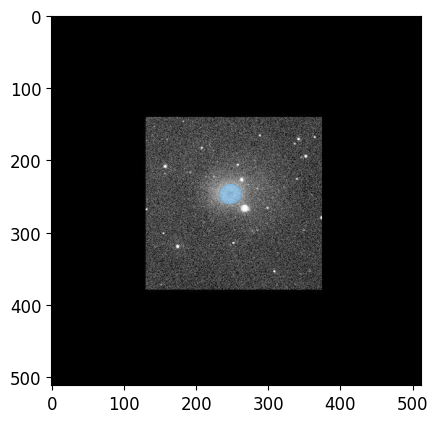

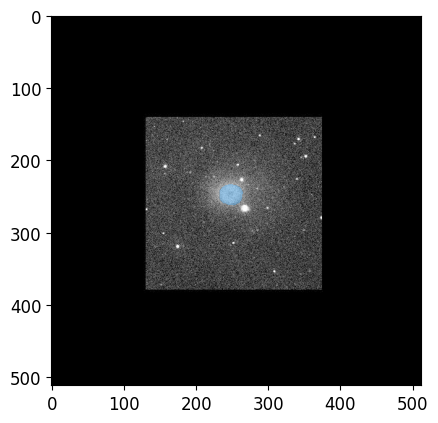

0.9023591 0.01807857


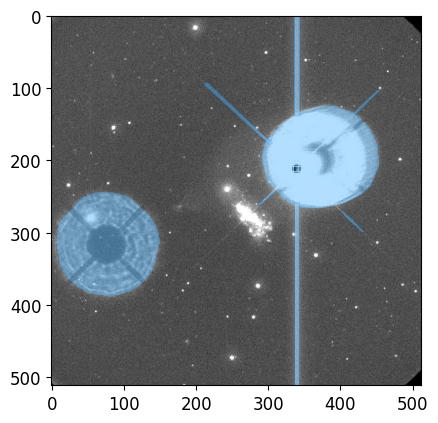

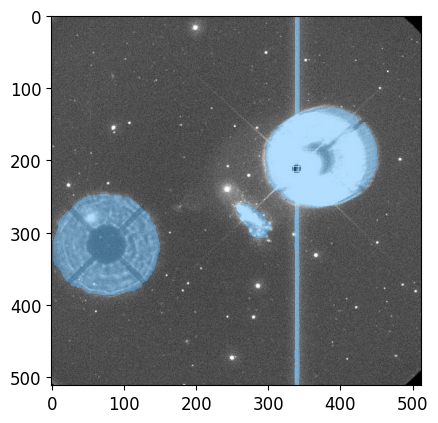

0.91836035 0.018602107


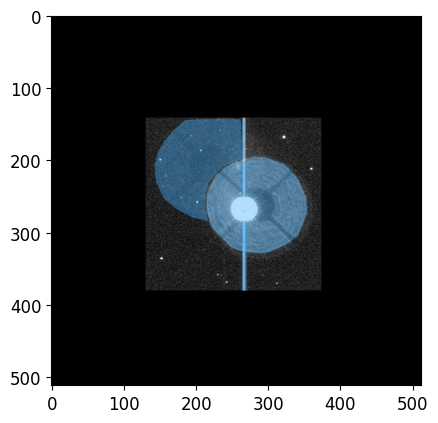

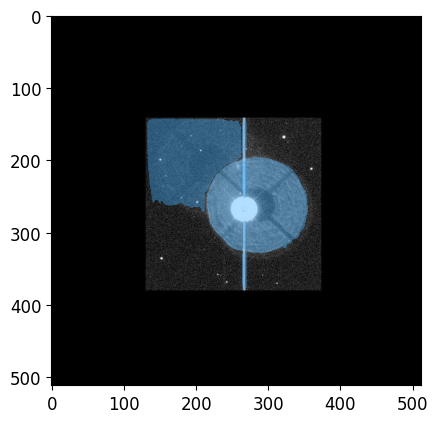

0.86080205 0.017092327


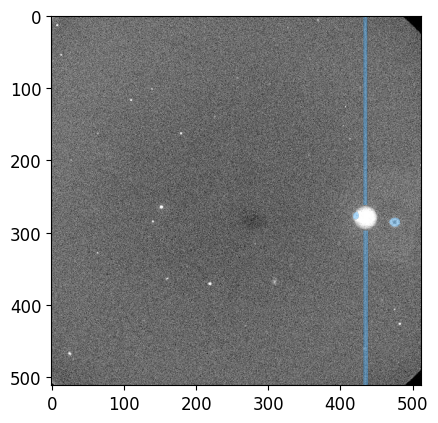

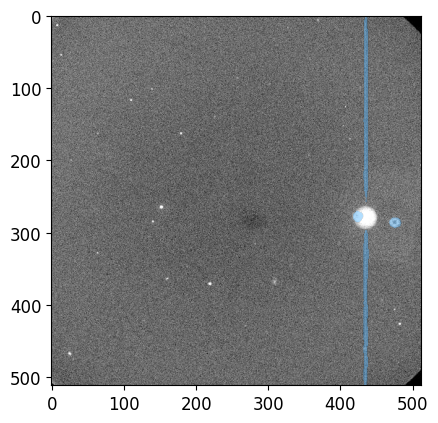

0.846011 0.052815333


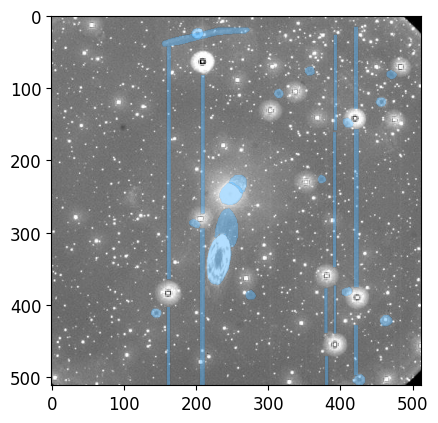

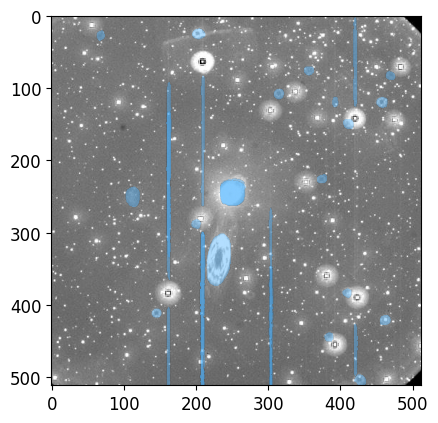

In [162]:
for j, (image_name, gt_mask, pred_mask, selected_iou) in enumerate(zip(images, selected_gts, selected_preds, selected_ious)):
    
        print(np.mean(selected_iou), np.std(selected_iou))
        gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512)) for i in range(len(valid_coco_data['annotations'])) \
                             if valid_coco_data['images'][valid_coco_data['annotations'][i]['image_id']]['file_name'].startswith(image_name.split(".")[0].replace("_png", ""))])
        gt_masks = gt_masks[:, None, :, :]
    
        ax_simple = axes[0, j]
        image = cv2.imread(valid_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
        ax_simple.imshow(255-image)
        ax_simple.set_xticks([])
        ax_simple.set_yticks([])
        ax_simple.set_title(f'{image_name.split(".")[0].replace("_png", "")}', fontsize=30, pad=10)

        for spine in ax_simple.spines.values():
            spine.set_linewidth(0)
            spine.set_edgecolor('whitesmoke')

        ax = axes[1, j]
        gt_mask = np.array(gt_mask)
        true_positive_mask, false_positive_mask, false_negative_mask = compute_metrics(gt_masks, pred_mask, ious[0], image)

In [154]:
import matplotlib.pyplot as plt
import numpy as np

num_instances = len(preds_per_image)
k=0
for i in range(num_instances):
    for j in range(len(preds_per_image[i]['masks'])):
        k+=1
        if k>20:
            break
        # if preds_per_image[i]["scores"][j] >0.9:
        if True:
            plt.figure(figsize=(20, 10))
            # Plot predicted mask
            plt.subplot(1, 2, 1)
            plt.imshow(preds_per_image[i]['masks'][j].numpy(), cmap='gray')
            plt.title(f'Predicted Label: {preds_per_image[i]["labels"][j].item()}, Score: {preds_per_image[i]["scores"][j].item():.2f}')
            plt.axis('off')
            
            # Plot target (ground truth) mask
            plt.subplot(1, 2, 2)
            plt.imshow(gts_per_image[i]['masks'][j].numpy(), cmap='gray')
            plt.title(f'True Label: {gts_per_image[i]["labels"][j].item()}')
            plt.axis('off')
        
            plt.show()
            plt.close()

NameError: name 'preds_per_image' is not defined

In [ ]:
a = 0
all=0
for i in range(num_instances):
    for j in range(len(preds_per_image[i]['masks'])):
        pred_mask = preds_per_image[i]['masks'][j].numpy()
        pred_label = preds_per_image[i]["labels"][j].item()
        score = preds_per_image[i]["scores"][j].item()
        gt_mask = gts_per_image[i]['masks'][j].numpy()
        gt_label = gts_per_image[i]["labels"][j].item()
        if pred_label == gt_label:
            a+=1
        all+=1
        
a, all, a/all

In [6]:
import glob
from roboflow import Roboflow
from dataset import dataset_utils, voc_annotate_and_Roboflow_export

def export_image_det_to_Roboflow(input_dir, filename, masks, obj_results):
    class_names = obj_results[0].names
    class_labels = obj_results[0].boxes.data[:, -1].int().tolist()
    
    objects = []
    for i in range(len(masks)):
        # masks[i]: [ 1, H, W]
        mask_np = masks[i].detach().cpu().numpy()
        polygon = voc_annotate_and_Roboflow_export.binary_image_to_polygon(mask_np[0])
        bbox = dataset_utils.mask_to_bbox(mask_np)
        if class_names[class_labels[i]] != 'read-out-streak':
            objects.append({
                'name': class_names[class_labels[i]],
                'bbox': bbox,
                'segmentations': polygon[0]
            })
    if len(objects)>0:
        voc_annotate_and_Roboflow_export.create_annotation_SAM(
            filename=filename, 
            width=512, 
            height=512, 
            depth=3, 
            objects=objects, 
            offset=1.2) # generating xml file for VOC format
        image_path = input_dir+filename
        annotation_filename = filename.replace(".png", ".xml")
        upload_project.upload(image_path, annotation_filename, overwrite=True)
        os.remove(annotation_filename)
    else:
        print("No objects after label filtering.")

In [46]:
import os
import torch
import cv2 

# Optional Roboflow export in VOC format given filenames
export_to_Roboflow = True
import time

# best_model = mobile_sam_model.cpu()
if export_to_Roboflow:
    # Initialize Roboflow client
    rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
    upload_project = rf.workspace("iuliaelisa").project("xmm_om_artefacts_512") # error if the project doesn't exist

new_images_dir = '../XMM_OM_dataset/zscaled_512_stretched/'
new_image_files =  os.listdir(new_images_dir)
# best_model.eval()
    
with torch.no_grad(): 
    # eg_img = 'S0018141301_M.png'
    for image_name in new_image_files[3350:5000]:
        print('Image', new_images_dir+image_name)
        image = cv2.imread(new_images_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        start_time = time.time()
        try:
            sam_mask_pre, obj_results = yolo_sam_pipeline.run_predict(new_images_dir + image_name) 
            # if export_to_Roboflow:
            #     export_image_det_to_Roboflow(new_images_dir, image_name, sam_mask_pre, obj_results)
                
        except Exception as e: # most likely the image had no annotations
            print(e)
            if export_to_Roboflow:
                upload_project.upload(new_images_dir+image_name)
            continue

loading Roboflow workspace...
loading Roboflow project...
Image ../XMM_OM_dataset/zscaled_512_stretched/S0201440101_U.png
name 'yolo_sam_pipeline' is not defined
Image ../XMM_OM_dataset/zscaled_512_stretched/S0804860201_U.png
name 'yolo_sam_pipeline' is not defined
Image ../XMM_OM_dataset/zscaled_512_stretched/S0741732801_L.png
name 'yolo_sam_pipeline' is not defined
Image ../XMM_OM_dataset/zscaled_512_stretched/S0606430401_V.png
name 'yolo_sam_pipeline' is not defined



KeyboardInterrupt



In [ ]:
# mobile_sam_state_dict = best_model.state_dict()

In [ ]:
# mobile_sam_state_dict.keys()

In [ ]:
# torch.save(yolov8_pretrained_model.state_dict(), 'yolo_model.bin')
# torch.save(best_model.state_dict(), 'pytorch_model.bin')

In [ ]:
# import json

# config_dict = {
#     "hidden_size": model.hidden_size,
#     "num_attention_heads": model.num_attention_heads,
#     "num_hidden_layers": model.num_hidden_layers,
# }

# with open("config.json", "w") as f:
#     json.dump(config_dict, f, indent=4)

In [ ]:
# yolov8_pretrained_model.export(format='onnx', imgsz=[512,512])

In [ ]:
# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')

# from importlib import reload
# from ft_mobile_sam import sam_model_registry, SamPredictor
# from ft_mobile_sam.utils.onnx import SamOnnxModel

# import onnxruntime
# from onnxruntime.quantization import QuantType
# from onnxruntime.quantization.quantize import quantize_dynamic

# import warnings
# onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

# onnx_model_path = "sam_onnx_example.onnx"

# sam = mobile_sam_model.to('cpu') # the model must be set on CP
# onnx_model = SamOnnxModel(sam, return_single_mask=True)

# dynamic_axes = {
#     "point_coords": {1: "num_points"},
#     "point_labels": {1: "num_points"},
# }

# embed_dim = sam.prompt_encoder.embed_dim
# embed_size = sam.prompt_encoder.image_embedding_size
# mask_input_size = [4 * x for x in embed_size]
# dummy_inputs = {
#     "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
#     "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
#     "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
#     "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
#     "has_mask_input": torch.tensor([1], dtype=torch.float),
#     # "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
# }
# output_names = ["masks", "iou_predictions", "low_res_masks"]

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
#     warnings.filterwarnings("ignore", category=UserWarning)
#     with open(onnx_model_path, "wb") as f:
#         torch.onnx.export(
#             onnx_model,
#             tuple(dummy_inputs.values()),
#             f,
#             export_params=True,
#             verbose=False,
#             opset_version=16,
#             do_constant_folding=True,
#             input_names=list(dummy_inputs.keys()),
#             output_names=output_names,
#             dynamic_axes=dynamic_axes,
#         )    

In [ ]:
# optional: export to ONNX

# !python scripts/export_onnx_model.py --checkpoint ./weights/mobile_sam.pt --model-type vit_t --output ./mobile_sam.onnx